In [11]:
# needed: Python 3.10-3.11

# requirements:
## pm4py>=2.7.11.13
## duckdb
## openai
## crewai
## crewai[tools]
## langchain
## langchain-openai
## requests

# you can install them with the command: pip install -U pm4py>=2.7.11.13 duckdb openai crewai crewai[tools] langchain langchain-openai requests

# in Colab, you can uncomment the following line:
# !pip install pm4py>=2.7.11.13 duckdb openai crewai crewai[tools] langchain langchain-openai requests

In [2]:
# imports the necessary requirements
from crewai import Crew, Agent, Task
from langchain_openai import ChatOpenAI
import pm4py
import duckdb
import os
from crewai_tools import tool
import pickle

In [3]:
# sets the API key (always needed!)
os.environ["OPENAI_API_KEY"] = open("api_key.txt", "r").read()

# sets the address of the APIs and the required model

# DeepInfra Qwen2-7B-Instruct
#llm = ChatOpenAI(model="Qwen/Qwen2-7B-Instruct", base_url="https://api.deepinfra.com/v1/openai/")

# OpenAI's GPT-4o Mini model 
llm = ChatOpenAI(model="gpt-4o-mini", base_url="https://api.openai.com/v1")

# OpenAI's GPT-3.5-turbo
#llm = ChatOpenAI(model="gpt-3.5-turbo", base_url="https://api.openai.com/v1")

In [4]:
# reads the event log in-memory using pm4py
log = pm4py.read_xes("renting_log_high.xes.gz")

# computes the DFG abstraction
dfg_abstraction = pm4py.llm.abstract_dfg(log)

/Users/urszulajessen/anaconda3/envs/agents/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 10000/10000 [00:03<00:00, 3155.56it/s]


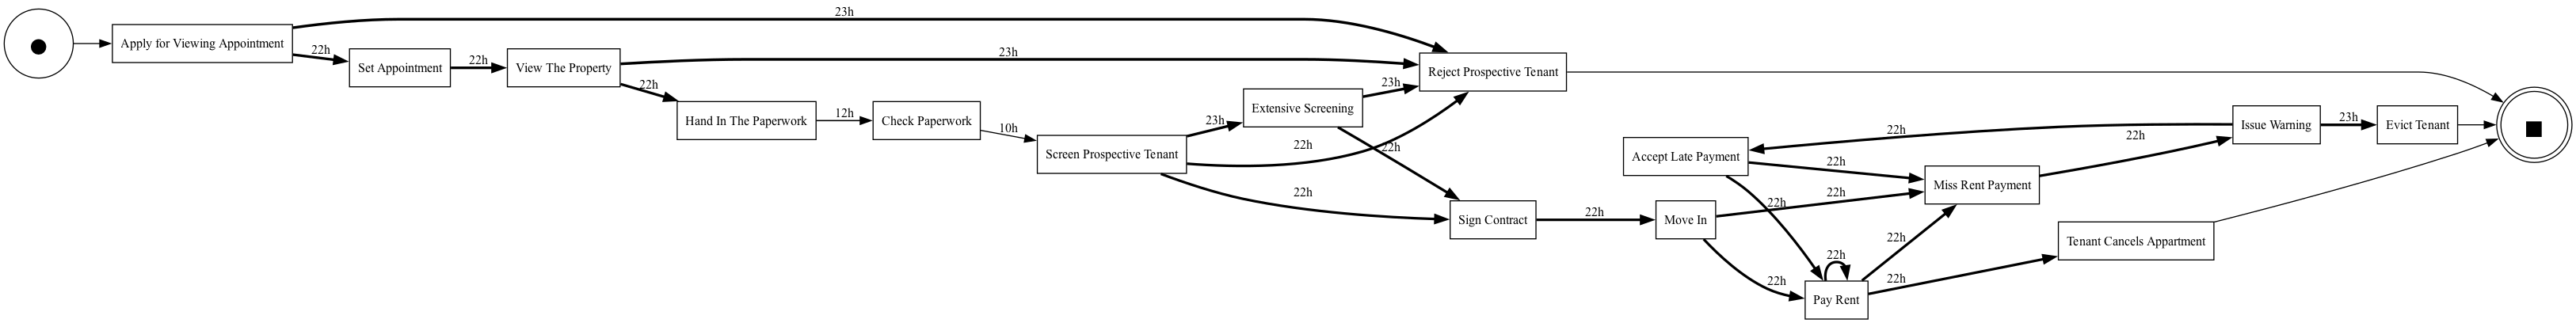

In [6]:
from pm4py.visualization.dfg import visualizer as dfg_visualizer

performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log)
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)


In [10]:
prompt = f"""
Given the proces Model {dfg_abstraction}, list 
the top three performance issues along with their possible root causes.
"""
#send the prompt to the llm model
from openai import OpenAI
client = OpenAI()

response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
   
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          #"text": "given this log analyze the performance issues and name possible root causes. List only top 3 performance issues with the possible root causes."
          "text": prompt
        }
      ]
    },
    {
      "role": "assistant",
      "content": [
        {
          "type": "text",
          "text": "Based on the provided process flow and performance data, here are the top three performance issues and their possible root causes:\n\n### 1. Check Paperwork -> Screen Prospective Tenant\n- **Performance:** 37,860.048\n- **Possible Root Causes:**\n  - Manual checks or verification steps that are time-consuming.\n  - Inadequate staffing to handle the volume of paperwork checks.\n  - Inefficiencies or bottlenecks in the handover process between paperwork checks and tenant screening.\n\n### 2. Set Appointment -> View The Property\n- **Performance:** 82,730.336\n- **Possible Root Causes:**\n  - Delays in scheduling or availability of property viewing slots.\n  - Lack of coordination between appointment setters and property managers.\n  - External factors such as tenant and property availability causing delays in viewing appointments.\n\n### 3. Extensive Screening -> Reject Prospective Tenant\n- **Performance:** 84,370.975\n- **Possible Root Causes:**\n  - Lengthy and possibly redundant screening processes.\n  - High frequency of negative outcomes causing extended decision-making time.\n  - Delays in receiving external information required for extensive screening (e.g., credit checks, background checks).\n\nThese performance issues suggest a need for process optimization,"
        }
      ]
    }
  ],
  temperature=1,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

In [20]:
# Extract and print the response content
formatted_response = response.choices[0].message.content
print(formatted_response)

perhaps by implementing automation, improving coordination, or reevaluating the criteria and steps involved at each stage. Here’s a more detailed approach to addressing these issues:

---

### 1. **Check Paperwork -> Screen Prospective Tenant**
- **Performance:** 37,860.048
- **Possible Countermeasures:**
  - **Automation:** Implement automated document verification tools to reduce manual workload.
  - **Training:** Enhance staff training to increase efficiency in document handling.
  - **Process Workflow:** Streamline the workflow by eliminating redundant checks or combining steps where possible.

### 2. **Set Appointment -> View The Property**
- **Performance:** 82,730.336
- **Possible Countermeasures:**
  - **Software Scheduling Tools:** Use advanced scheduling software to better manage and optimize viewing appointments.
  - **Resource Allocation:** Reallocate administrative resources to ensure quicker appointment setting.
  - **Communication Channels:** Improve communication betwee

In [15]:
# defines three agents:
# - the first one specialized in root cause analysis identification
# - the second one specialized in explaining the root cause analysis insights
# - the third one acting as a judge, giving a score from 1.0 to 10.0 to the previous insights
# the agents have all a 'role', a 'goal', a 'backstory', and are connected to the provided LLM.

pm_root_cause_analyst = Agent(role="root_cause_analyst", goal="Perform root cause analysis in process mining.", backstory="Finds all the root causes of the performance issues.", llm=llm)
pm_root_cause_explainer = Agent(role="root_cause_explainer", goal="Explaining process mining insights to non-technical people.", backstory="Very detailed analyst.", llm=llm)
pm_insights_grader = Agent(role="insights_grader", goal="Giving a score to the process mining insights proposed by others.", backstory="Judge.", llm=llm)


In [16]:
# defines the tasks of the three agents

root_cause_analysis = Task(description="Find the root causes of the performance issues in the process. Only process and data specific considerations, not general considerations. DFG abstraction: {dfg_abstraction}", expected_output="The chain of thought related to the insight", agent=pm_root_cause_analyst)
root_cause_chain_of_thought = Task(description="Explain the first of the provided insight in detail. Original DFG abstraction: {dfg_abstraction}", expected_output="The chain of thought related to the insight", agent=pm_root_cause_explainer)
root_cause_grader = Task(description="Provide a grade from 1.0 (minimum) to 10.0 (maximum) for all the provided root cause insights. Original DFG abstraction: {dfg_abstraction}", expected_output="A list of insights, each accompanied by a grade.", agent=pm_insights_grader)


In [17]:
# defines the crew

#print(os.environ["OPENAI_API_KEY"])
crew = Crew(agents=[pm_root_cause_analyst, pm_root_cause_explainer, pm_insights_grader], tasks=[root_cause_analysis, root_cause_chain_of_thought, root_cause_grader], verbose=True)

2024-06-25 14:26:15,198 - 8396700352 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


In [18]:
# starts the crew

crew.kickoff({"dfg_abstraction": dfg_abstraction})

 [2024-06-25 14:26:15][DEBUG]: == Working Agent: root_cause_analyst
 [2024-06-25 14:26:15][INFO]: == Starting Task: Find the root causes of the performance issues in the process. Only process and data specific considerations, not general considerations. DFG abstraction: If I have a process with flow:

Pay Rent -> Pay Rent ( frequency = 14819  performance = 81120.304 )
Set Appointment -> View The Property ( frequency = 9151  performance = 82730.336 )
Apply for Viewing Appointment -> Set Appointment ( frequency = 9151  performance = 82731.269 )
View The Property -> Hand In The Paperwork ( frequency = 7441  performance = 81965.052 )
Hand In The Paperwork -> Check Paperwork ( frequency = 7441  performance = 44106.173 )
Check Paperwork -> Screen Prospective Tenant ( frequency = 7441  performance = 37860.048 )
Screen Prospective Tenant -> Reject Prospective Tenant ( frequency = 2856  performance = 81282.616 )
Screen Prospective Tenant -> Extensive Screening ( frequency = 2793  performance = 

'Here are the grades for the provided root cause insights:\n\n1. **Scheduling Conflicts**:\n   - **Insight**: Appointments are often overlapped or booked too closely together, leading to delays.\n   - **Example**: An agent has back-to-back appointments scheduled without sufficient buffer time, causing them to run late for subsequent appointments.\n   - **Detail**: The scheduling system does not currently account for potential overruns in previous appointments or unforeseen circumstances that might delay an agent.\n   - **Grade**: 9.0\n\n2. **Property Readiness Delays**:\n   - **Insight**: Properties are sometimes not ready for viewing at the scheduled time, leading to cancellations or rescheduling.\n   - **Example**: A property may still be undergoing cleaning or maintenance when a prospective buyer arrives.\n   - **Detail**: Coordination between property management and scheduling is inadequate, leading to misaligned timings. There is no real-time update mechanism to inform agents or c

'Here are the grades for the provided root cause insights:\n\n1. **Scheduling Conflicts**:\n   - **Insight**: Appointments are often overlapped or booked too closely together, leading to delays.\n   - **Example**: An agent has back-to-back appointments scheduled without sufficient buffer time, causing them to run late for subsequent appointments.\n   - **Detail**: The scheduling system does not currently account for potential overruns in previous appointments or unforeseen circumstances that might delay an agent.\n   - **Grade**: 9.0\n\n2. **Property Readiness Delays**:\n   - **Insight**: Properties are sometimes not ready for viewing at the scheduled time, leading to cancellations or rescheduling.\n   - **Example**: A property may still be undergoing cleaning or maintenance when a prospective buyer arrives.\n   - **Detail**: Coordination between property management and scheduling is inadequate, leading to misaligned timings. There is no real-time update mechanism to inform agents or clients about the current status of property readiness.\n   - **Grade**: 9.5\n\n3. **Travel Time Issues**:\n   - **Insight**: Insufficient travel time allocation between appointments causes delays.\n   - **Example**: An agent needs to travel across town to reach the next property, but only a minimal travel time has been allocated in the schedule.\n   - **Detail**: The scheduling system does not consider traffic conditions, distance, or possible delays in transit when setting appointments. This oversight often results in an agent being late for their next appointment.\n   - **Grade**: 9.0'